# Description

RNAmut takes RNA reference and alternative nucleotide read counts as input.
The input format should be equivalent to the example data files reference_reads.csv and alternative_reads.csv (apart from the size).

An algorithm (scores.py/calculate_pmat) transfers the read counts to probabilities of mutation. To model the nucleotide read counts 
in relation to the total coverage, the algorithm uses a beta-binomial distribution.
The algorithms parameters include two overdispersion terms (overdispersion_mut for the mutated and overdispersion_wt for the non-mutated case)
describing the shape of the beta distributions (overdispersion = alpha + beta). Furthermore the parameters include an allelic dropout term (dropout)
and the prior probability of mutation (prior_p_mutation). RNAmut can be used to optimize these parameters using a Metropolis-Hastings algorithm and 
to draw samples from the posterior probability distributions. Additionally, this program tries to derive the phylogenetic relation inbetween single cells to find the cell lineage trees and parameters, which best 
explain the observed read counts. The tree consists of the possible mutation sites, with the cells attached to them.
Cells attached to the root have no mutations in any of the mutation sites. A cell attached to another part of the tree has the mutation 
it is attached to and all the mutations of its ancestors. This approach is based on SCIPHI "https://www.nature.com/articles/s41467-018-07627-7".

As optional outputs, we have on the one hand the calculated probabilities of mutation, making use of the best parameters. 
On the other hand the mutations derived from the best cell lineage trees. In addition, a graphviz file to visualize the tree and all samples 
collected after the burn-in phase can be produced as well.

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import savetxt
import random
from random import gauss
from scipy.stats import gmean

In [2]:
# Options

moveProbsParams = [0.25, 0.4, 0.35, 0.05]           # probabilities of different moves: 
                                                    # 1.  range (0,1): determines the probability that in one round of the Metropolis-Hastings algorithm
                                                    #     the parameters are updated, one minus this probability is the probability that the trees are updated
                                                    # 2.  prune&re-attach: prune a subtree and re-attach it to the main tree
                                                    # 3.  swap node labels: two nodes are randomly chosen and their labels exchanged
                                                    # 4.  swap subtrees: swap subtrees only if nodes in different lineages, else prune&re-attach
                                                    # 2,3 and 4 are weights -> they don't have to sum up to 1
            
oodp = [100, 1, 0.2, 0.1]                           # initial values for overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation

priorAlphaBetaoodp = [2, 10, 2, 2, 1.5, 3, 2, 18]   # for the two overdispersion, dropout and mutation parameters, a prior beta distribution is specified:
                                                    # alpha overdispersion_wt, beta overdispersion_wt, alpha overdispersion_mut, beta overdispersion_mut, 
                                                    # alpha dropout, beta dropout, alpha prior_p_mutation, beta prior_p_mutation

covDiagonal = [1, 0.001, 0.0002, 0.00001]           # initial covariance Matrix is all zeros expcept these values in the diagonal from upper left to lower right
                                                    # the covariance matrix is learned adaptively and it's used for drawing from a multivariate normal distribution
                                                          
maxValues = [1000, 2, 1, 1]                         # the maximum values for the parameters overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation
                                                    # values larger than (maximum_value - 0.00001) are not considered

minValues = [0,0,0,0]                               # the minimal values for the parameters overdispersion_wt, overdispersion_mut, dropout, prior_p_mutatio
                                                    # values smaller than (minimum_value + 0.00001) are not considered

outFile = "tree"                                    # the name of the output files
frequency_of_nucleotide = 0.5                       # expected allele frequency
sequencing_error_rate = 0.01                        # if small, it has little effect on the mutation probability
reps = 1                                            # number of repetitions of the MCMC
loops = 100000                                      # number of loops within a MCMC
initialPeriod = 10000                               # number of iterations before the initial covariance matrix is adapted 
sampleStep = 1                                      # stepsize between sampling of parameters and trees/ 1 -> sampled every round, 2 -> sampled every second round,...
burnInPhase = 0.25                                  # burn-in loops / total number of loops

decVar = 0.1                                        # the covariance matrix is multiplied with this factor, to increase or decrease it 0.1 -> 10 times smaller
                                                    # increases or decreases the acceptance rate

adaptAcceptanceRate = True                          # if true starts with given decVar, but adapts it every 1000 loops, if the acceptance rate lies outside 1/4 to 1/2

factorParamsLogScore = 10                           # is multiplied with the parameter log score to increase or decrease its influence compared to the tree log score
                                                    # -> Helps to prevent empty tree solution (all cells attached to the root).

factor_owt = 2                                      # is additionally multiplied with the overdisperison_wt log-score, because this is the main parameter 
                                                    # responsible for the empty tree solution.

marginalization = True                              # if false the program maximizes the placement of the cells, if true the program tries to find the marginal 
                                                    # distribution of the parameters.

optTreeOutputNum = 3                                # determines the maximal number of optimal trees for the output, if output_gv = True and / or output_mut_csv = True
                                                    # if = -1 -> no restrictions on the output size

output_mut_csv = True                               # if true outputs 1,0 mutation matrix of optimal trees / marginalization should be False
output_gv = True                                    # if true outputs graphviz file of optimal trees / marginalization should be False
output_samples = True                               # if true outputs all samples after burn-in of current log-score, current tree log-score,
                                                    # current parameters and curent parent vector as numpy array
output_sampleParams = True                          # if true outputs all samples after burn-in of current parameters and current log-score as numpy array
output_ProbabilityMatrix = True                     # if true outputs probability matrix of best parameters as csv file

path = "../input/read-count-matrices/"              # specify the main path to the files
alt_file = "alternative_reads.csv"                  # name of alternative read file
ref_file = "reference_reads.csv"                    # name of reference read file

In [3]:
# Load files
pd_ref = pd.read_csv(path + ref_file, sep = ",")
pd_alt = pd.read_csv(path + alt_file, sep = ",")
gene_names = list(pd_ref.iloc[:,0])
cell_names = list(pd_ref.columns[1:])

# Replace NANs with 0
ref = np.array(pd_ref.fillna(0))[:,1:].tolist()
alt = np.array(pd_alt.fillna(0))[:,1:].tolist()

# Determine number of cells and mutation sites
num_mut = len(ref) # number of mutations is equal to the number of rows

num_cells = len(ref[1]) # number of cells is equal to the number of columns

print("Number of mutation sites:", num_mut, " Number of cells:", num_cells)

rows_alt = len(alt)
columns_alt = len(alt[1])

if num_mut != rows_alt:
    print("The number of mutation sites is not the same in files", ref_file, "and", alt_file)

if num_cells != columns_alt:
    print("The number of cells s is not the same in files", ref_file, "and", alt_file)

Number of mutation sites: 26  Number of cells: 33


In [4]:
# Functions to convert read counts to mutation probabilities and to calculate the paramter and tree log-scores

import math
import numpy as np


# Convert read counts to mutation probabilities
def calculate_pmat(overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation, frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref):
    """
    Args:
        overdispersion_wt       - overdispersion wildtype (non-mutated case) (float)
        overdispersion_mut      - overdispersion mutation (mutated case) (float)
        dropout                 - dropout rate (float)
        prior_p_mutation        - prior probability of a mutation occurring (float)
        frequency_of_nucleotide - expected allele frequency (float)
        sequencing_error_rate   - sequencing error rate (float)
        num_mut                 - number of mutation sites (int)
        num_cells               - number of cells (int)
        alt                     - alternative read counts (list)
        ref                     - wildtype/reference read counts (list)
        
    Returns:
        pmat                    - mutation probabilities (numpy array)
    """
    alpha_wt = overdispersion_wt * sequencing_error_rate
    beta_wt = overdispersion_wt * (1 - sequencing_error_rate)

    alpha_mut = overdispersion_mut * (frequency_of_nucleotide - 1/3 * sequencing_error_rate) 
    beta_mut = overdispersion_mut * (1 - (frequency_of_nucleotide - 1/3 * sequencing_error_rate))

    pmat = np.zeros((num_mut, num_cells))
    
    # alpha_wt + beta_wt = overdispersion_wt
    # alpha_mut + beta_mut = overdispersion_mut
    gamma_const_nor = math.lgamma(overdispersion_wt) - math.lgamma(alpha_wt) - math.lgamma(beta_wt)
    gamma_const_mut = math.lgamma(overdispersion_mut) - math.lgamma(alpha_mut) - math.lgamma(beta_mut)
    
    # sc.gammaln(c + 1) and - sc.gammaln(c - s + 1) and - sc.gammaln(s + 1) are the same for all terms 
    # -> they cancel out and it is not necessary to calculate them
    for i in range(num_mut):
        for j in range(num_cells):    

            c = ref[i][j] + alt[i][j]  # total_coverage
            s = alt[i][j]  # alternative nucleotide_counts (mutated)
            
            if (c == 0):
                pmat[i][j] = prior_p_mutation
                continue
            
            gamma_core =  gamma_const_nor - math.lgamma(c + overdispersion_wt)
            
            p_nor = math.lgamma(s + alpha_wt) + math.lgamma(c - s + beta_wt) + gamma_core  
            p_nor = (math.e**(p_nor))
            
            p_mut = (dropout/2) * (p_nor) \
                    + (dropout/2) * math.e**(math.lgamma(s + beta_wt) + math.lgamma(c - s + alpha_wt) + gamma_core) \
                    + (1 - dropout) * math.e**(math.lgamma(s + alpha_mut) + math.lgamma(c - s + beta_mut) \
                    + gamma_const_mut - math.lgamma(c + overdispersion_mut))

            pmat[i][j] = (p_mut * prior_p_mutation)/((p_mut * prior_p_mutation) + (p_nor * (1 - prior_p_mutation)))
            
    pmat[pmat > 0.9999] = 0.9999 # highest allowed probability of mutation
    pmat[pmat < 0.0001] = 0.0001 # lowest
    return pmat


# Logarithm of probability density function (pdf) of the beta distribution at point x
def log_pdf(a, b, x):
    """
    Args:
        a - alpha (float)
        b - beta (float)
        x - range: (0,1) / probability density is determined at point x (float)
        
    Returns:
        Logarithm of probability density function (float)
    """
    return math.lgamma(a + b) - math.lgamma(a) - math.lgamma(b) + (a - 1) * math.log(x) + (b - 1) * math.log(1 - x)


# Logarithmic tree score
# Uses the logarithmic scoring rule to determine the difference between the calculated probabilities of mutation 
# and the one zero mutation probabilities derived from the mutation tree
# Marginalization of the attachment points is possible (to get posterior distributions of the learnable parameters)
def log_scoretree(pmat, parVec, marginalization, num_mut, num_cells):
    """
    Args:
        pmat            - calculated probabilities of mutation (numpy array)
        parVec          - parent vector of tree (list)
        marginalization - if true the attachment points are marginalized (bool)
        num_mut         - number of mutation sites (int)
        num_cells       - number of cells (int)
        
    Returns:
        log_score       - logarithmic tree score (float)
    """
    log_pmat_m = np.log(pmat)
    log_pmat_r = np.log(1 - pmat)
    
    log_score = 0

    children = [[] for v in range(num_mut + 1)]
    for q in range(num_mut):
        children[parVec[q]].append(q) 

    # determine where the mutation_sites are located in the tree 
    # to later be able to add the log score from root to bottom of the tree
    bf = [0] * (num_mut + 1)
    bf[0] = num_mut
    z = 0

    for w in range(num_mut + 1):
        for t in range(len(children[bf[w]])):
            z += 1
            bf[z] = children[bf[w]][t]           
                                                 
    # add to log-score
    for i in range(num_cells):
        
        score = [0] * (num_mut + 1)
        
        for j in range(num_mut):
            score[num_mut] += log_pmat_r[j,i] 
        
        for k in range(1, num_mut + 1):
                       
            node = bf[k]

            score[node] = score[parVec[node]]
            score[node] += log_pmat_m[node,i]   # step by step the mutation log score is added 
            score[node] -= log_pmat_r[node,i]   # because the mutation replaces a reference, the reference log score is substracted

        if marginalization == False:
            log_score += max(score)
            
        if marginalization == True:
            log_score += max(score) + math.log(sum(math.e ** (score - max(score))))

    return log_score


# Logarithmic parameter score
# The factorParamsLogScore determines how strongly the prior parameter distributions affect the combined tree and parameters log score
# Because a small overdispersion_wt parameter might lead to an empty tree solution, meaning none of the cells are predicted to have a mutation, 
# it is possible to strengthen the prior for this parameter with the factor_owt.
def log_scoreparams(params, maxValues, priorAlphaBetaoodp, factor_owt, factorParamsLogScore):
    """
    Args:
        params               - [overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation] (list)
        maxValues            - maximum values of the parameters (list)
        priorAlphaBetaoodp   - prior alphas and betas of the parameter beta distributions (list)
        factor_owt           - strengthens/(weakens) prior of overdispersion_wt (int/float)
        factorParamsLogScore - strengthens/weakens priors (int/float)
        
    Returns:
        Logarithmic parameters score (float)
    """
    log_score = 0            
    log_score += log_pdf(priorAlphaBetaoodp[0], priorAlphaBetaoodp[1], params[0] / maxValues[0]) * factor_owt   # overdispersion_wt
    log_score += log_pdf(priorAlphaBetaoodp[2], priorAlphaBetaoodp[3], params[1] / maxValues[1])                # overdispersion_mut
    log_score += log_pdf(priorAlphaBetaoodp[4], priorAlphaBetaoodp[5], params[2] / maxValues[2])                # dropout
    log_score += log_pdf(priorAlphaBetaoodp[6], priorAlphaBetaoodp[7], params[3] / maxValues[3])                # prior_p_mutation
    
    return log_score * factorParamsLogScore

In [5]:
# Functions used for initializing and optimizing cell lineage trees.
# The tree consists of the possible mutation sites. The cells are attached to the tree.
# A cell attached to the root has no mutation in any of the mutation sites.
# A cell attached to another part of the tree has the mutation it is attached to and all
# mutations of its ancestors.


# Converts Prüfer code to parent vector
def prüfer_to_parent(code, codelen):
    """
    Args:
        code    - prüfer code (list)
        codelen - length of Prüfer code (int)
        
    Returns:
        par_vec - parent vector (list)
    """
    root = codelen + 2        # same as node count
    par_vec = [0] * (codelen + 1)
    baum = []

    for s in range(codelen):
        comb = code + baum
        for c in range(codelen + 1):
            si = 0
            for l in comb:
                if (c == l):
                    si = 1
                    break
            if (si == 0):
                break

        baum.append(c)
        par_vec[c] = code.pop(0)

    # the last two remaining nodes treated seperately
    last = []

    for l in range(root):
        si = 0
        for b in baum:
            if (l == b):
                si = 1
                break
        if si == 0:
            last.append(l)

    par_vec[last[0]] = last[1]
    return par_vec

                
# Creates a random parent vector -> This is used to start the tree optimization with a random tree
def getRandParentVec(n):
    """
    Arg:
        n - length of parent vector (int)
        
    Returns:
        Parent vector (list)
    """
    randCode = []
    codelen = n - 1
    
    for i in range(codelen):                         # length of Prüfer code
        randCode.append(random.randint(0, n))               # random Prüfer code with n+1 nodes
        
    return prüfer_to_parent(randCode, codelen)


# Determines ancestor matrix from parent vector
def parentVector2ancMatrix(parVec, n):
    """
    Args:
        parVec    - parent vector (list)
        n         - length of parent vector (int)
        
    Returns:
        ancMatrix - ancestor matrix (numpy array)
    """
    ancMatrix = np.zeros((n,n))
    for j in range(n):
        ancMatrix[j][j] = 1     # mutation counted as it's own ancestor
     
    for i in range(n):
        a = i
        while a < n:
            if parVec[a] < n:
                ancMatrix[parVec[a]][i] = 1
            a = parVec[a]
        
    return ancMatrix


# Is used in the Metropolis-Hastings algorithm to propose new cell lineage trees similar to the current tree
def proposeNewTree(moveProbsParams, ancMatrix, currTreeParentVec, num_mut):
    """
    Args:
        moveProbsParams   - determines the weights of the three move types (prune&re-attach, swap node labels, swap subtrees) (list)
        ancMatrix         - ancestor matrix of current parent vector (numpy array)
        currTreeParentVec - parent vector of current tree (list)
        num_mut           - number of mutation sites
        
    Returns:
        propTreeParentVec - parent vector of proposal tree (list)
    """
    moveType = random.choices([1,2,3], weights = (moveProbsParams[1], moveProbsParams[2], moveProbsParams[3]), k = 1)[0]
    
    if (moveType == 3):  # swap two subtrees in different lineages
        
        swapNodes = np.random.choice(num_mut, 2, replace=False)
        if (ancMatrix[swapNodes[1]][swapNodes[0]] == 0) and (ancMatrix[swapNodes[0]][swapNodes[1]] == 0):

            propTreeParentVec =  currTreeParentVec
            propTreeParentVec[swapNodes[1]] =  currTreeParentVec[swapNodes[0]]
            propTreeParentVec[swapNodes[0]] =  currTreeParentVec[swapNodes[1]]
            
        else:
            moveType = 1
            
    if (moveType == 1):     # prune and re-attach 
        nodeToMove = random.randrange(num_mut)   # pick a node to move with its subtree
        possibleParents = []

        for i in range(num_mut):
            if ancMatrix[nodeToMove][i] == 0:
                possibleParents.append(i)                        # possible attachment points
                
        newParent = random.choice(possibleParents + [num_mut])   # randomly pick a new parent among available nodes, root (num_mut + 1) is also possible parent
                                           
        propTreeParentVec =  currTreeParentVec
        propTreeParentVec[nodeToMove] = newParent
        
        
        
    if (moveType == 2):         # swap two nodes
        switchNodes = np.random.choice(num_mut, 2, replace=False)
        propTreeParentVec =  currTreeParentVec[:]
        
        for j in range(num_mut):
            
            if((currTreeParentVec[j] == switchNodes[0]) and (j != switchNodes[1])):   # change the parent of the children
                propTreeParentVec[j] = switchNodes[1]
                
            if((currTreeParentVec[j] == switchNodes[1]) and (j != switchNodes[0])):
                propTreeParentVec[j] = switchNodes[0]
                        
        propTreeParentVec[switchNodes[1]] = currTreeParentVec[switchNodes[0]]   # switch the nodes
        propTreeParentVec[switchNodes[0]] = currTreeParentVec[switchNodes[1]]
        
        if(propTreeParentVec[switchNodes[1]] == switchNodes[1]):     # if one is the parent of the other
            propTreeParentVec[switchNodes[1]] = switchNodes[0]
        
        if(propTreeParentVec[switchNodes[0]] == switchNodes[0]):
            propTreeParentVec[switchNodes[0]] = switchNodes[1]

    return propTreeParentVec

In [6]:
# Functions for running the parameter and tree optimization using a metropolis-hastings algorithm

# If the new score is better, the move is accepted
# If it is worse, the probability of acceptance depends on how much worse it is
def acceptance(x_logs, x_new_logs):
    """
    Args:
        x_logs      - previous log score (float)
        x_new_logs  - new log score (float)
        
    Returns:
        Accepted or not (bool)
    """
    if x_new_logs > x_logs:
        return True
    
    else:
        accept = np.random.uniform(0,1)
        return (accept < (math.e**(x_new_logs - x_logs)))
      

# Used to draw samples from a multivariate normal distribution
def sample_multivariate_normal(x, cov):
    """
    Args:
        x     - previous parameters (list)
        cov   - covariance matrix (numpy array)
        
    Returns:
        x_new - new parameters (list)
    """
    n = len(x)
    x_new = [0,0,0,0]
    chol = np.linalg.cholesky(cov)
    un = [gauss(0,1),gauss(0,1),gauss(0,1),gauss(0,1)]
    
    for i in range(n):
        for j in range(n):
            x_new[i] += float(chol[i][j]) * un[j]
        x_new[i] += x[i]
    return x_new
  
    
# Runs the Markov chain Monte Carlo (MCMC)/ Metropolis Hastings algorithm.
# It samples from the posterior paramter distributions / optimizes the parameters, muatation tree and the attachment of cells
def runMCMCoodp(reps, loops, oodp, priorAlphaBetaoodp, moveProbsParams, sampleStep, initialPeriod, adaptAcceptanceRate, \
                covDiagonal, maxValues, minValues, burnInPhase, decVar, factor_owt, factorParamsLogScore, marginalization, \
                frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref):
    """
    Args:
        reps                    - number of repetitions of the MCMC (int)
        loops                   - number of loops within a MCMC (int)
        oodp                    - initial values for overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation (list)
        priorAlphaBetaoodp      - alphas and betas of prior parameter distributions (list)
        moveProbsParams         - probabilities of different moves [parameters updated, prune&re-attach, swap node labels, swap subtrees] (list)
        sampleStep              - stepsize between sampling of parameters and trees (int)
        initialPeriod           - number of iterations before the initial covariance matrix is adapted (int)
        adaptAcceptanceRate     - if true starts with given decVar, but adapts it every 1000 loops, if the acceptance rate lies outside 1/4 to 1/2
        covDiagonal             - initial values of the covariance matrix in the diagonal from upper left to lower right (list)
        maxValues               - the maximum values for the parameters overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation (list)
        minValues               - the minimal values for the parameters overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation (list)
        burnInPhase             - burn-in loops / total number of loops (float)
        decVar                  - the covariance matrix is multiplied with this factor (float)
        factor_owt              - is multiplied with the overdisperison_wt log-score (float/int)
        factorParamsLogScore    - is multiplied with the parameter log score to increase or decrease its influence compared to the tree log score (float/int)
        marginalization         - false -> optimizes the tree, the placement of cells, true -> marginal distribution of the parameters (bool)
        frequency_of_nucleotide - expected allele frequency (float)
        sequencing_error_rate   - sequencing error rate (float)
        num_mut                 - number of mutation sites (int)
        num_cells               - number of cells (int)
        alt                     - alternative read counts (list)
        ref                     - wildtype/reference read counts (list)
        
    Returns:
        sample                  - all samples after burn-in of current tree log-score, current params and curent parent vector (list)
        sampleParams            - all samples after burn-in of current parameters and current log-score (list)
        optimalTreelist         - all optimal trees that are not equivalent and current parameters (list)
        bestParams              - optimal parameters (list)
    """
    optStatesAfterBurnIn = 0
    n = len(oodp)  # number of parameters
    burnIn = loops * burnInPhase
    parentVectorSize = num_mut
    eps = 0.00000000001
    optimalTreelist = []
    sample = []
    sampleParams = []
    newtree = True
    bestScore = bestTreeLogScore = -1000000
    
    for r in range(reps):       # starts over, but keeps sampling, bestScore, bestTreeLogScore

        av_params_t = np.array(oodp)
        currTreeParentVec = getRandParentVec(parentVectorSize)     # start MCMC with random tree
        currTreeAncMatrix =  parentVector2ancMatrix(currTreeParentVec, parentVectorSize)
        currParams = oodp
        pmat = calculate_pmat(currParams[0], currParams[1], currParams[2], currParams[3], frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
        currpmat = pmat
        currTreeLogScore = log_scoretree(pmat, currTreeParentVec, marginalization, num_mut, num_cells)
        currParamsLogScore = log_scoreparams(currParams, maxValues, priorAlphaBetaoodp, factor_owt, factorParamsLogScore)
        currScore = currTreeLogScore + currParamsLogScore
        
        if currScore > bestScore:
            bestScore = currScore
            bestTreeLogScore = currTreeLogScore
            bestParams = currParams

        moveAcceptedParams = 0
        totalMovesParams = lastmoveAcceptedParams = 0
        moveAcceptedTrees = 0
        totalMovesTrees = lasttotalMoveParams = 0
        
        t = 1

        cov_mat = np.zeros((n,n))
        for z in range(n):
            cov_mat[z, z] = covDiagonal[z] * decVar
            
        for l in range(loops):
            
            if(l % 10000 == 0):
                print("At mcmc repetition " , r + 1 , "/" , reps , ", step " , l , " best tree score: " , bestTreeLogScore \
                , " and best overdispersion_wt: " , bestParams[0] , ", best overdispersion_mut: " , bestParams[1] , ", best dropout: " \
                , bestParams[2] , ", best prior_p_mutation: " , bestParams[3] , " and best overall score: " , bestScore , "\n", sep = "")

            if (adaptAcceptanceRate == True) and (l % 1000 == 999):
                currAcceptedMoveParams  = moveAcceptedParams - lastmoveAcceptedParams
                currtotalMoveParams = totalMovesParams - lasttotalMoveParams
                
                if currAcceptedMoveParams / currtotalMoveParams > 0.5:
                    decVar *= 1.1
                    
                if currAcceptedMoveParams / currtotalMoveParams < 0.25:
                    decVar *= 0.9
                    
                lasttotalMoveParams = totalMovesParams
                lastmoveAcceptedParams = moveAcceptedParams
                
            rand = np.random.uniform(0,1)
            if rand < moveProbsParams[0]:         # true if this move changes parameters, not the tree
                
                totalMovesParams += 1
                propParams = sample_multivariate_normal(currParams, cov_mat)

                #if the proposed parameters are out of range (or close to), they are not considered
                if (propParams[0] < (minValues[0] + 0.00001)) or (propParams[0] > (maxValues[0] - 0.00001)) or (propParams[1] < (minValues[1] + 0.00001)) \
                   or (propParams[1] > (maxValues[1] - 0.00001)) or (propParams[2] < (minValues[2] + 0.00001)) or (propParams[2] > (maxValues[2] - 0.00001)) \
                   or (propParams[3] < (minValues[3] + 0.00001)) or (propParams[3] > (maxValues[3] - 0.00001)):
                    continue 
                
                propParamsLogScore = log_scoreparams(propParams, maxValues, priorAlphaBetaoodp, factor_owt, factorParamsLogScore)
                pmat = calculate_pmat(propParams[0], propParams[1], propParams[2], propParams[3], frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
                propTreeLogScore = log_scoretree(pmat, currTreeParentVec, marginalization, num_mut, num_cells)
                propScore = propTreeLogScore + propParamsLogScore

                if acceptance(currScore, propScore):  # the proposed move is accepted
                    moveAcceptedParams += 1
                    currTreeLogScore  = propTreeLogScore
                    currParams = propParams
                    currParamsLogScore = propParamsLogScore
                    currScore = propScore
                    currpmat = pmat
                    
                if (l > 0.9 * initialPeriod):
                    t += 1
                    av_params_t += (np.array(currParams) - av_params_t) / t
                    
                if (l > initialPeriod):
                    cov_mat = (t - 1)/t * (cov_mat  +  1/t * np.dot(np.transpose([currParams - av_params_t]), [currParams - av_params_t]) * decVar) + eps * np.identity(4)

        
            else:                 # if the move changes the tree not the parameter
                totalMovesTrees += 1
                propTreeParentVec = proposeNewTree(moveProbsParams, currTreeAncMatrix[:], currTreeParentVec[:], num_mut)
                propTreeLogScore = log_scoretree(currpmat, propTreeParentVec, marginalization, num_mut, num_cells)
                
                if acceptance(currTreeLogScore, propTreeLogScore):                   # the proposed tree is accepted
                    moveAcceptedTrees += 1
                    currTreeAncMatrix = parentVector2ancMatrix(propTreeParentVec, parentVectorSize)
                    currTreeParentVec = propTreeParentVec                                
                    currTreeLogScore  = propTreeLogScore                     
                    currScore = currTreeLogScore + currParamsLogScore
                    
            if currScore > bestScore:       # create a list with optimal trees and parameters
                optimalTreelist = []
                optimalTreelist.append([currTreeParentVec, currParams])

            if (currScore >= bestScore - eps) and (currScore <= bestScore + eps): # might not be necessary to use eps
                for o in optimalTreelist:
                    newtree = False
                    for u in range(num_mut):
                        if o[0][u] != currTreeParentVec[u]:
                            newtree = True
                            break
                            
                    if newtree == False:
                        break
                
                if (newtree == True):
                    optimalTreelist.append([currTreeParentVec, currParams])
                    
                if (l >= burnIn):
                    optStatesAfterBurnIn += 1
                    

            if(l >= burnIn and (l % sampleStep == 0) and (rand < moveProbsParams[0])):
                sampleParams.append([currParams, currScore])
                
            if(l >= burnIn and l % sampleStep == 0):
                sample.append([currScore, currTreeLogScore, currParams, currTreeParentVec])
            
            if(currScore > bestScore + eps):
                optStatesAfterBurnIn = 1          
                bestTreeLogScore = currTreeLogScore
                bestScore = currScore
                bestParams = currParams

    noStepsAfterBurnin = reps * (loops - burnIn)

    print( "best log score for tree: " , bestTreeLogScore)
    print( "optimal steps after burn-in: " , optStatesAfterBurnIn)
    print( "total #steps after burn-in: ", noStepsAfterBurnin)
    print( "percentage of optimal steps after burn-in: " , optStatesAfterBurnIn / noStepsAfterBurnin)
    print( "percentage of new Parameters accepted:", (moveAcceptedParams / totalMovesParams) * 100, "%")
    print( "percentage of Tree moves accepted:", (moveAcceptedTrees / totalMovesTrees) * 100, "%")
    
    if(moveProbsParams[0] != 0):
        print( "best value for overdispersion_wt: " , bestParams[0])
        print( "best value for overdispersion_mut: " , bestParams[1])
        print( "best value for  dropout: " , bestParams[2])
        print( "best value for  prior_p_mutation: " , bestParams[3])
        print( "best log score for (Tree, Params): " , bestScore)

    return sample, sampleParams, optimalTreelist, bestParams

In [7]:
# Run Markov chain Monte Carlo / Metropolis Hastings algorithm
samples, sampleParams, optimal, bestParams = runMCMCoodp(reps, loops, oodp, priorAlphaBetaoodp, moveProbsParams, sampleStep, initialPeriod, adaptAcceptanceRate, \
                                                         covDiagonal, maxValues, minValues, burnInPhase, decVar, factor_owt, factorParamsLogScore, marginalization, \
                                                         frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)

At mcmc repetition 1/1, step 0 best tree score: -587.790343058726 and best overdispersion_wt: 100, best overdispersion_mut: 1, best dropout: 0.2, best prior_p_mutation: 0.1 and best overall score: -531.0280548705077

At mcmc repetition 1/1, step 10000 best tree score: -68.19674526897147 and best overdispersion_wt: 77.57070725246533, best overdispersion_mut: 0.8312598707809628, best dropout: 0.2176924111707633, best prior_p_mutation: 0.015338210111852957 and best overall score: -15.860143438087277

At mcmc repetition 1/1, step 20000 best tree score: -68.49306043526634 and best overdispersion_wt: 73.19714122731122, best overdispersion_mut: 0.9738018381091746, best dropout: 0.21413029924167964, best prior_p_mutation: 0.01623294286482716 and best overall score: -15.762922958352824

At mcmc repetition 1/1, step 30000 best tree score: -68.49306043526634 and best overdispersion_wt: 73.19714122731122, best overdispersion_mut: 0.9738018381091746, best dropout: 0.21413029924167964, best prior_p_

In [8]:
# Functions used to create the desired output files

# Determines the optimal attachment points of the cells to the mutation tree
def getAttachmentPoints(parVec, params, num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate, alt, ref):
    """
    Args:
        parVec                  - parent vector (list)
        params                  - [overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation] (list)
        num_mut                 - number of mutation sites (int)
        num_cells               - number of cells (int)
        frequency_of_nucleotide - expected allele frequency (float)
        sequencing_error_rate   - sequencing error rate (float)
        
    Returns:
        attachmentPoints        - optimal attachment points (list)
    """    
    pmat = calculate_pmat(params[0], params[1], params[2], params[3], frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
    
    log_pmat_m = np.log(pmat)
    log_pmat_r = np.log(1 - pmat)
    
    attachmentPoints = []
    
    children = [[] for v in range(num_mut + 1)]
    for q in range(num_mut):
        children[parVec[q]].append(q) 

    # determine where the mutations are located in the tree to later be able to 
    # add the log score from root to bottom of the tree
    bf = [0] * (num_mut + 1)
    bf[0] = num_mut
    z = 0

    for w in range(num_mut + 1):
        for t in range(len(children[bf[w]])):
            z += 1

            bf[z] = children[bf[w]][t]           
                                                 
    for i in range(num_cells):
        
        score = [0] * (num_mut + 1)
        
        for j in range(num_mut):
            score[num_mut] += log_pmat_r[j,i] 
        
        for k in range(1, num_mut + 1):
                       
            node = bf[k]
            
            # step by step the mutation log score is added and because the mutation replaces a reference, 
            # the reference log score is substracted.
            score[node] = score[parVec[node]]
            score[node] -= log_pmat_r[node,i] 
            score[node] += log_pmat_m[node,i] 

        attachmentPoints.append(score.index(max(score)))
    return attachmentPoints
  
    
# Calculates a one zero mutation matrix
# All cells are optimally attached to the muatation tree
def oneZeroMut(params, parVec, num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate):
    """
    Args:
        params                  - [overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation] (list)
        parVec                  - parent vector of tree (list)
        num_mut                 - number of mutation sites (int)
        num_cells               - number of cells (int)
        frequency_of_nucleotide - expected allele frequency (float)
        sequencing_error_rate   - sequencing error rate (float)
        
    Returns:
        mat                     - one zero matrix (numpy array)
    """    
    ancMatrix = parentVector2ancMatrix(parVec, num_mut)
    
    attachmentPoints = getAttachmentPoints(parVec, params, num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate, alt, ref)

    mat = np.zeros((num_mut, num_cells))

    for m, j in enumerate(attachmentPoints):
        if(j < num_mut):
            for k in range(num_mut):
                if (ancMatrix[k][j] == 1):
                    mat[k][m] = 1

    return mat
  

# Creates a graphviz file
def graphviz(params, parVec, num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate, gene_names):
    """
    Args:
        params                  - [overdispersion_wt, overdispersion_mut, dropout, prior_p_mutation] (list)
        parVec                  - parent vector of tree (list)
        num_mut                 - number of mutation sites (int)
        num_cells               - number of cells (int)
        frequency_of_nucleotide - expected allele frequency (float)
        sequencing_error_rate   - sequencing error rate (float)
        gene_names              - The names of the mutation sites (list)
        
    Returns:
        gv                      - graphviz file (string)
    """    
    gene_names.append("Root")
    
    gv = "digraph G {\n"
    gv += "node [color=deeppink4, style=filled, fontcolor=white];\n"

    for i in range(num_mut):
        # the parantheses around the gene names help displaying them if they contain special characters
        gv += ("\"" + gene_names[parVec[i]] + "\"" + " -> "  + "\"" + gene_names[i]  + "\"" + ";\n" ) 

    gv += "node [color=lightgrey, style=filled, fontcolor=black];\n"
                            
    attachmentPoints = getAttachmentPoints(parVec, params, num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate, alt, ref)
    
    for y, a in enumerate(attachmentPoints):
        gv += "\"" + gene_names[a] + "\"" + " -> s"  + str(y + 1) + ";\n"

    gv += "}\n"
    return gv

In [9]:
# Create all desired output files

# Uses the best parameters to calculate the probability of mutation using the RNA read counts
if output_ProbabilityMatrix == True:           
    pmat = calculate_pmat(bestParams[0], bestParams[1], bestParams[2], bestParams[3], frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
    savetxt(outFile + "_pmat.csv", pmat, delimiter = ",")

    
# If true outputs 1,0 mutation matrix
if output_mut_csv == True:                               
    if optTreeOutputNum == -1:
        optTreeOutputNum = len(optimal)
        
    for o, opt in enumerate(optimal):
        if o >= optTreeOutputNum:
            break
        mut = oneZeroMut(opt[1], opt[0], num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate)
        savetxt(outFile + "_mut_" + str(o) + ".csv", mut, delimiter = ',')
        

# If true outputs graphviz file of optimal trees
if output_gv == True:
    if optTreeOutputNum == -1:
        optTreeOutputNum = len(optimal)
        
    for o, opt in enumerate(optimal):
        if o >= optTreeOutputNum:
            break
        gv = graphviz(opt[1], opt[0], num_mut, num_cells, frequency_of_nucleotide, sequencing_error_rate, gene_names)
        with open( outFile + "_" + str(o) + ".gv", "w") as text_file:
            text_file.write(gv)

            
# Outputs all samples as np.array
if output_samples == True:
    samples = np.array(samples)
    np.save(outFile + "_samples", samples)

# Outputs all parameter samples as np.array
if output_sampleParams == True:
    sampleParams = np.array(sampleParams)
    np.save(outFile + "_sampleParams", sampleParams)

# Visualizations

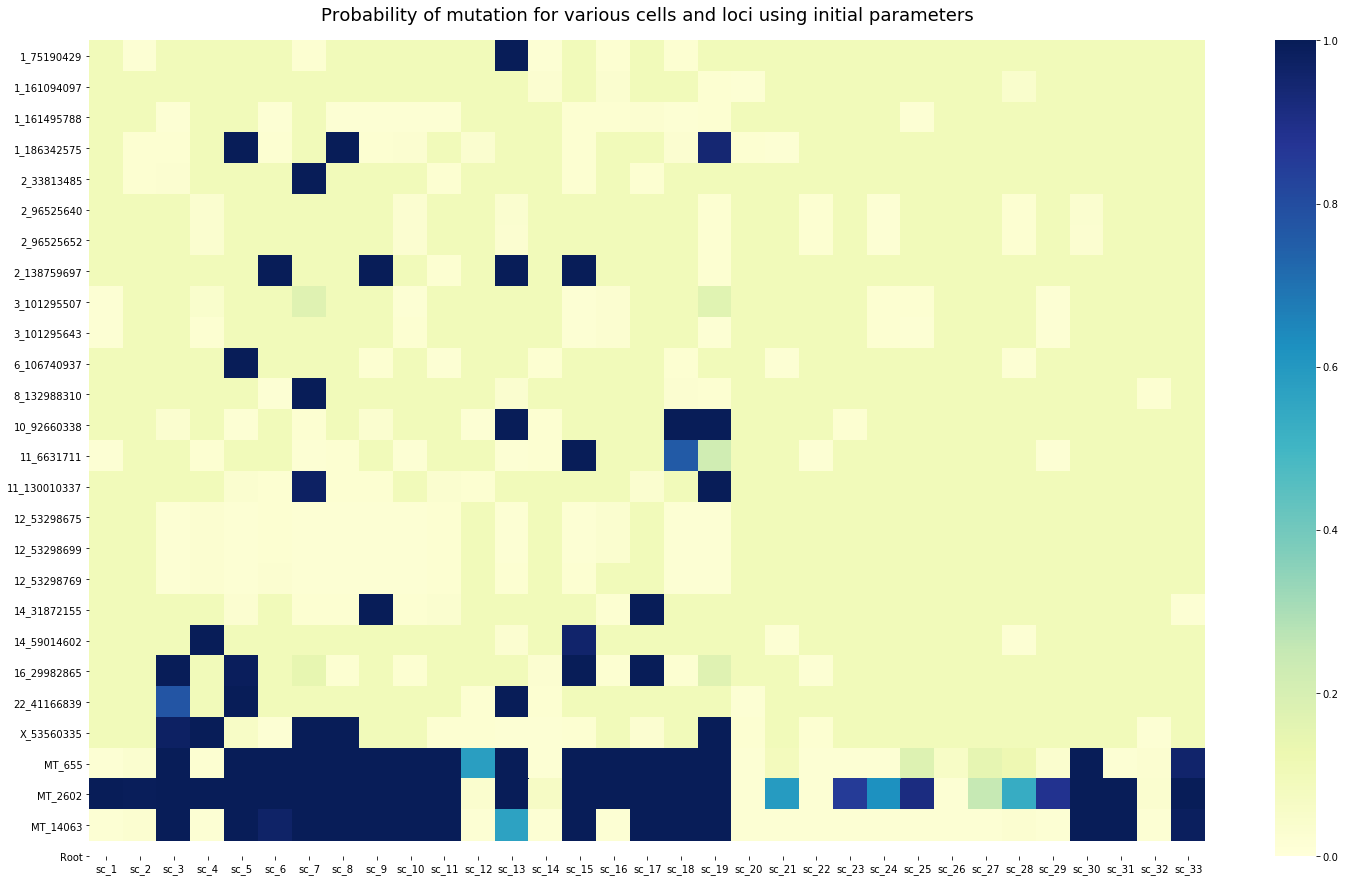

In [10]:
pmat = calculate_pmat(100, 1, 0.2, 0.1, frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
                 
plt.figure(figsize = (25,15))
plt.title("Probability of mutation for various cells and loci using initial parameters", pad = 20, fontsize=18)
sns.heatmap(pmat, vmin = 0, vmax = 1, xticklabels= cell_names, yticklabels=gene_names, cmap="YlGnBu")
plt.show()

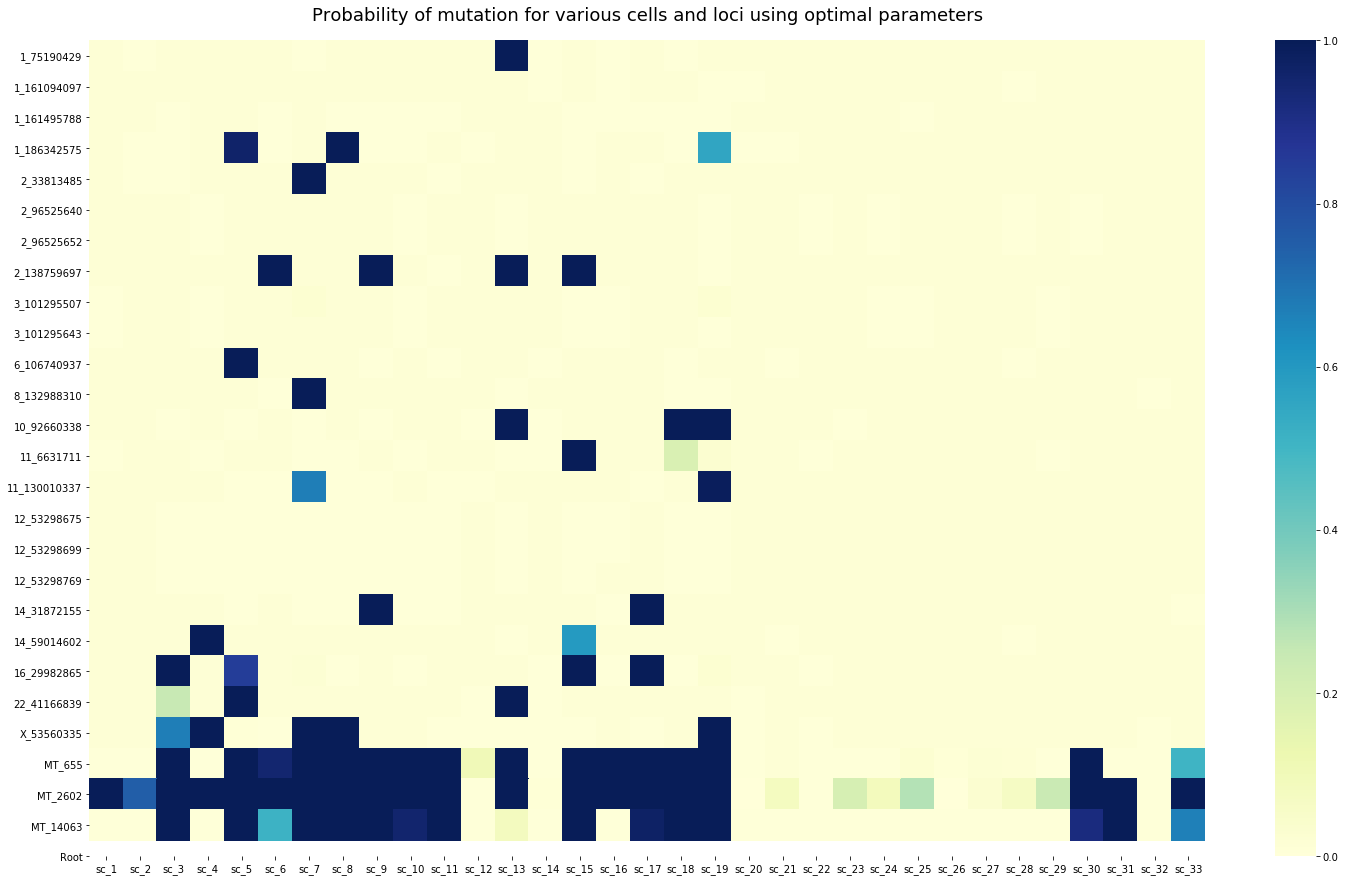

In [11]:
pmat = calculate_pmat(optimal[0][1][0], optimal[0][1][1], optimal[0][1][2], optimal[0][1][3], frequency_of_nucleotide, sequencing_error_rate, num_mut, num_cells, alt, ref)
                 
plt.figure(figsize = (25,15))
plt.title("Probability of mutation for various cells and loci using optimal parameters", pad = 20, fontsize=18)
sns.heatmap(pmat, vmin = 0, vmax = 1, xticklabels= cell_names, yticklabels=gene_names, cmap="YlGnBu")
plt.show()

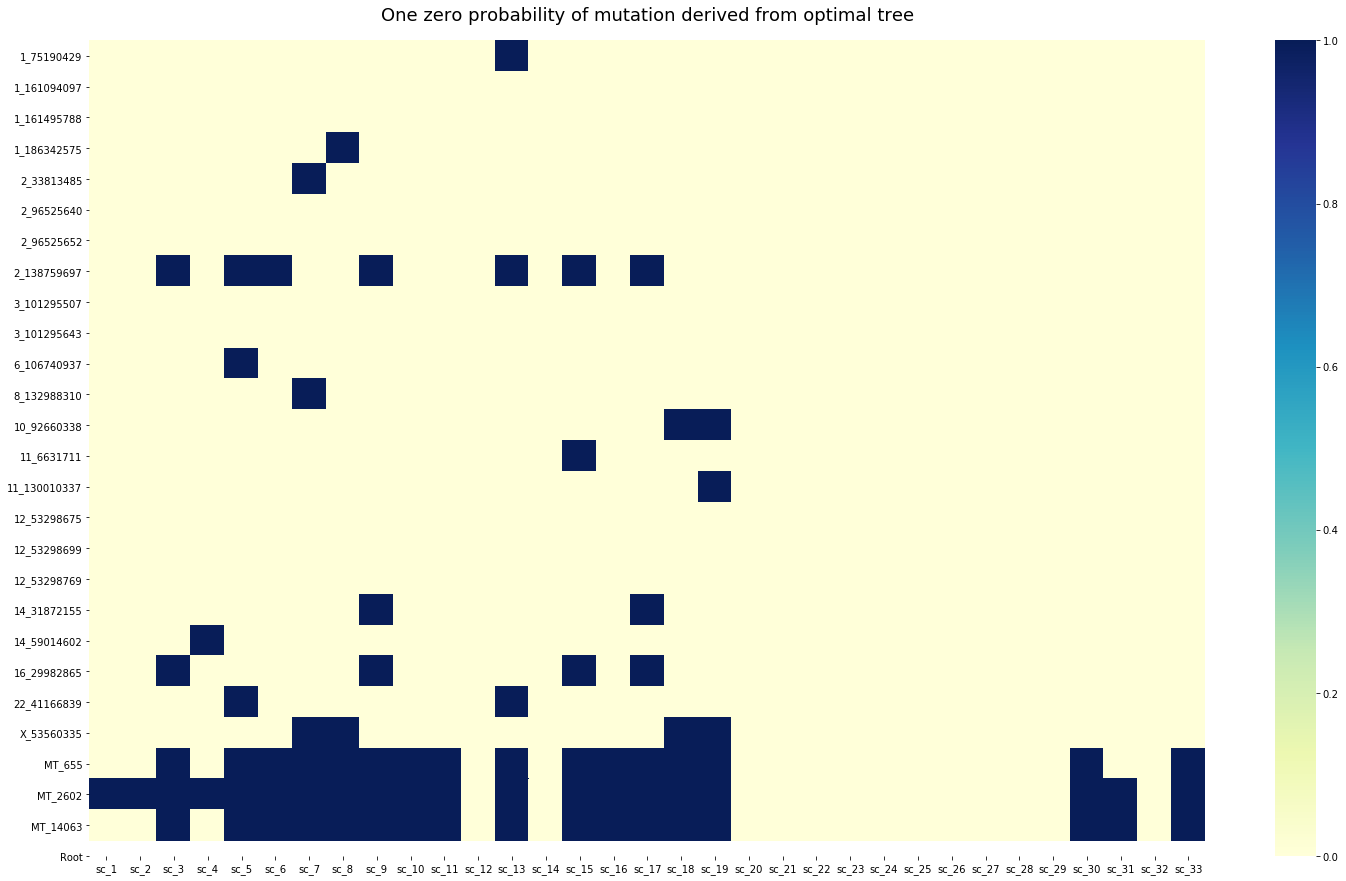

In [12]:
plt.figure(figsize = (25,15))
plt.title("One zero probability of mutation derived from optimal tree", pad = 20, fontsize=18)
sns.heatmap(mut, vmin = 0, vmax = 1, xticklabels= cell_names, yticklabels=gene_names, cmap="YlGnBu")
plt.show()

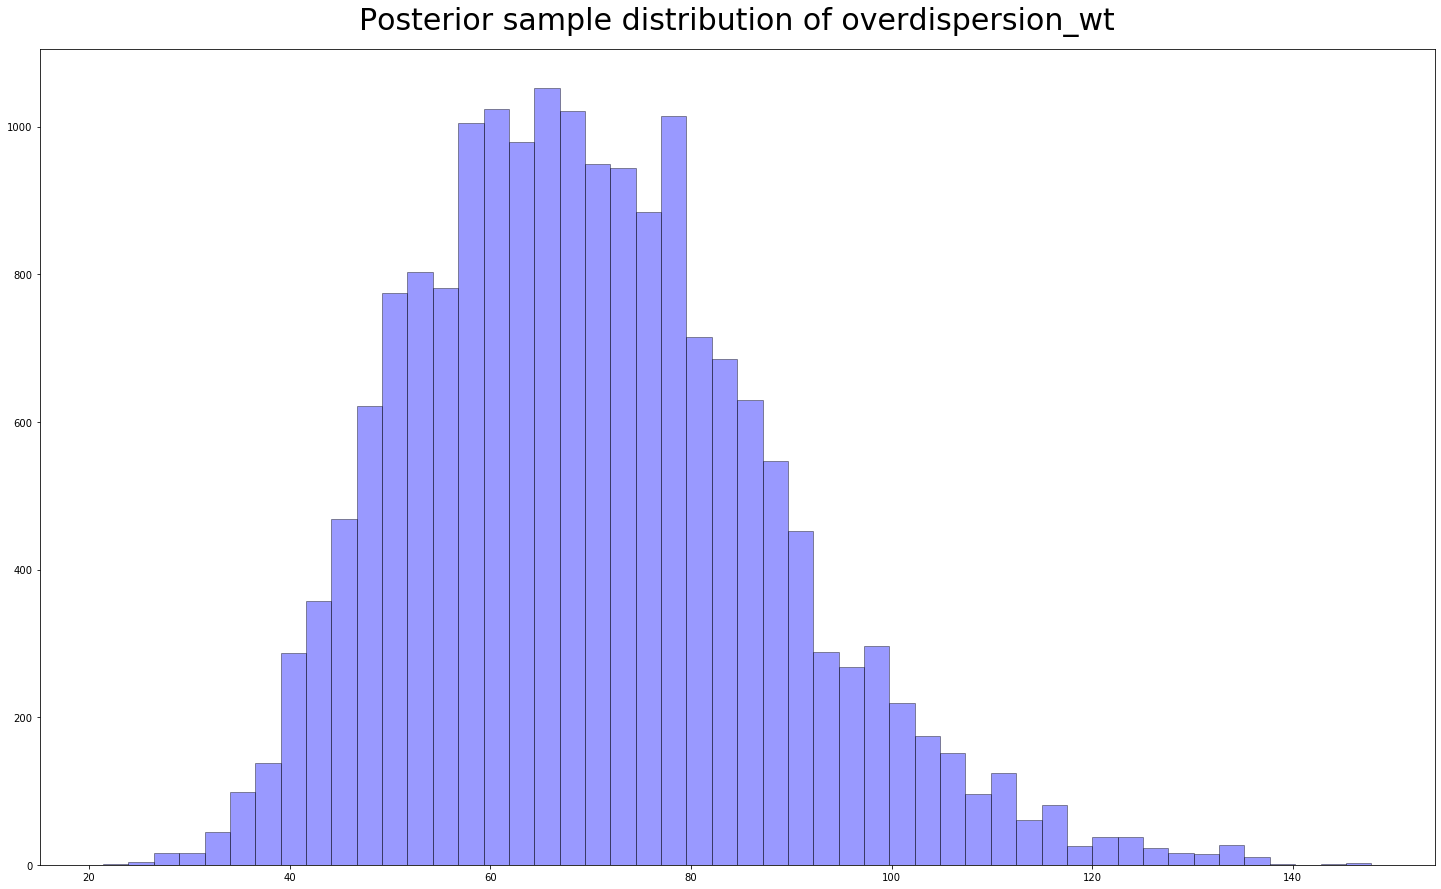

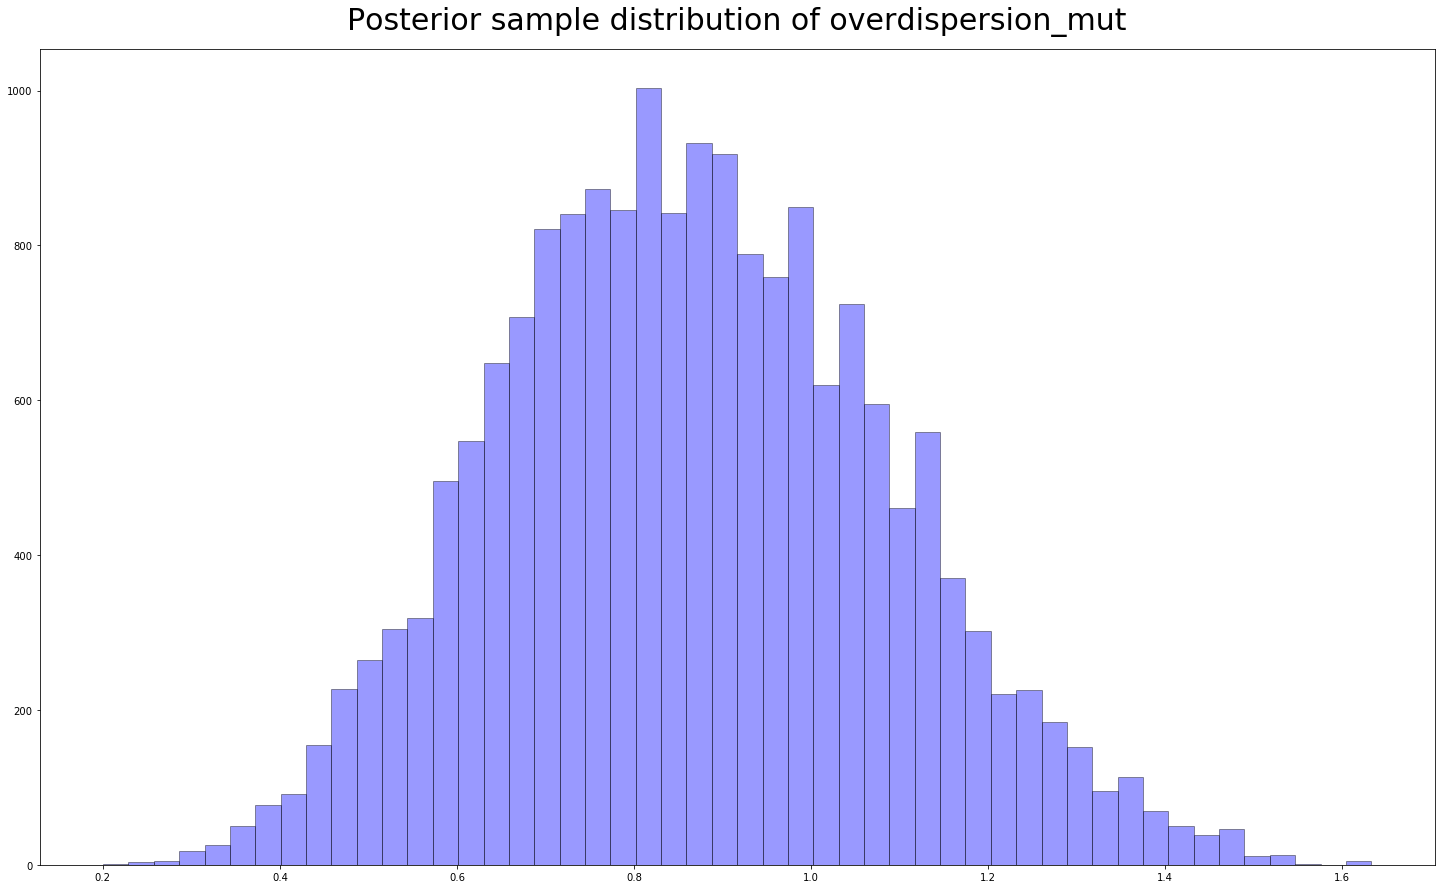

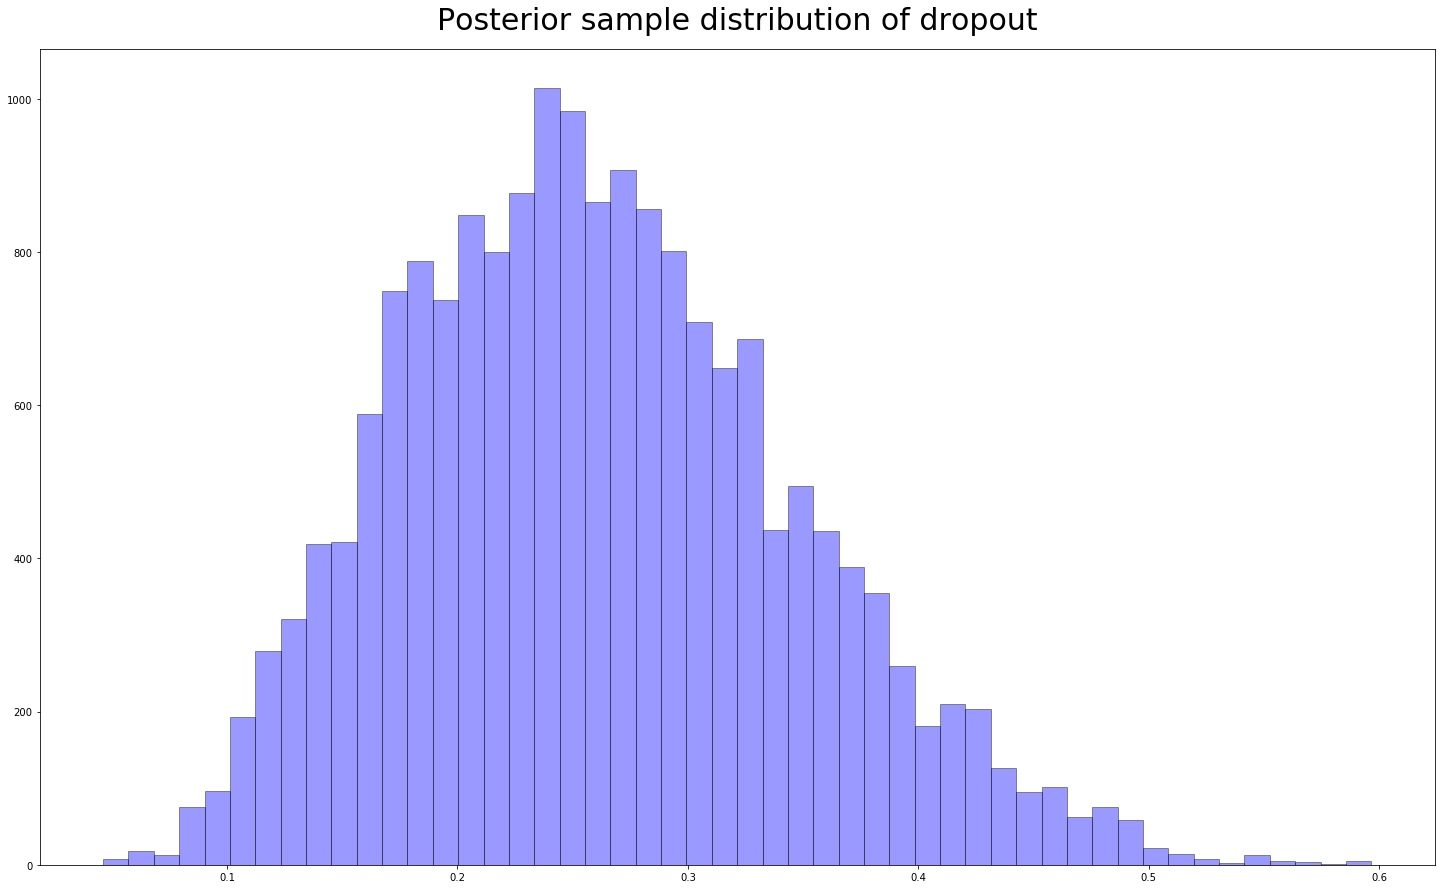

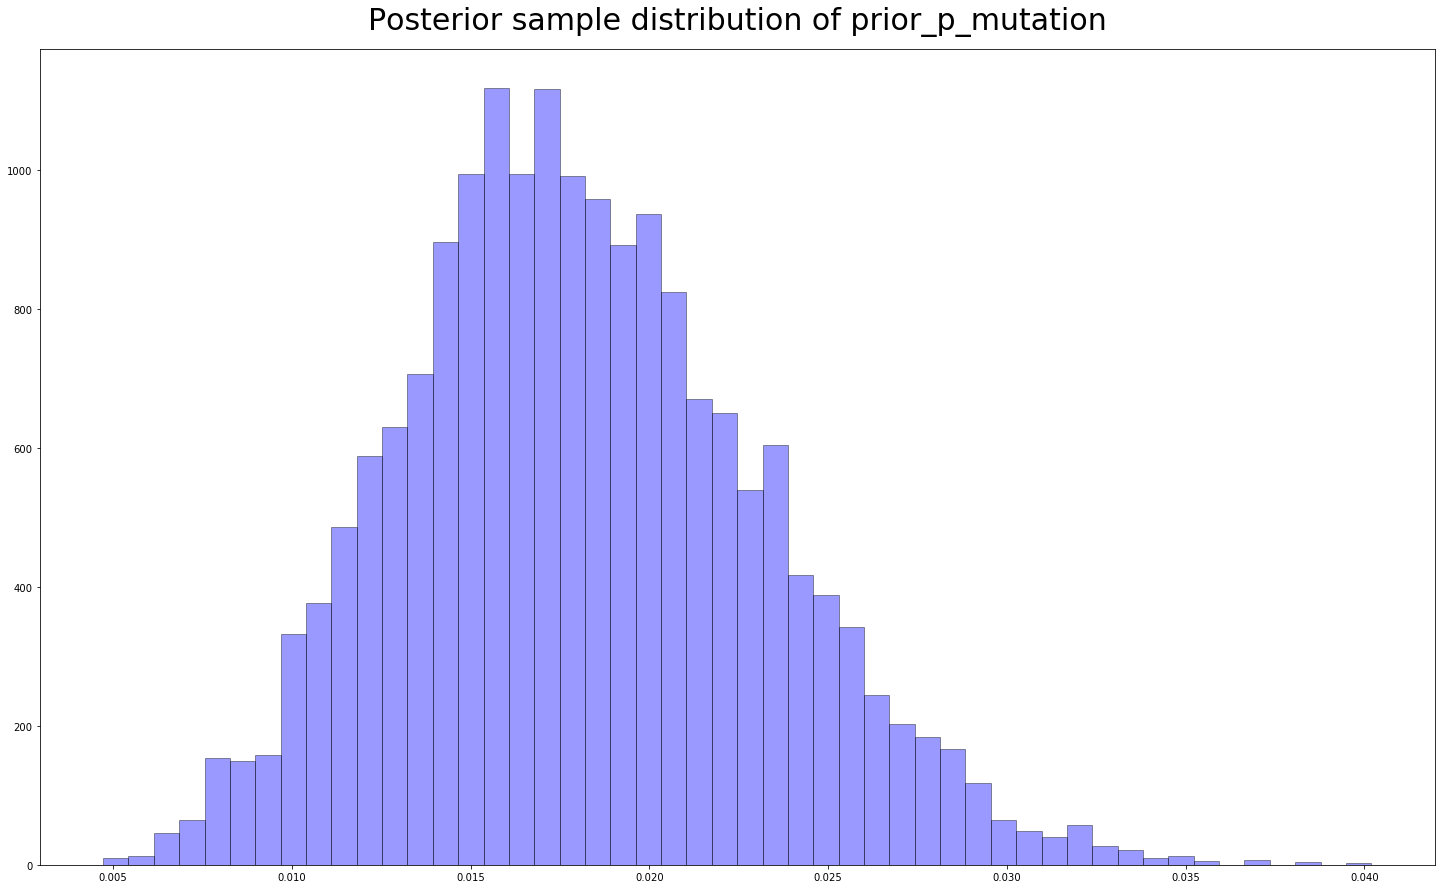

In [13]:
titles = ["Posterior sample distribution of overdispersion_wt", "Posterior sample distribution of overdispersion_mut", \
          "Posterior sample distribution of dropout", "Posterior sample distribution of prior_p_mutation"]

for n in range(4):
    
    plt.figure(figsize = (25,15))
    plt.title(titles[n],{'fontsize': 30}, pad = 20)
    x = np.arange(0,50)

    sns.distplot([r[n] for r in [row[0] for row in sampleParams]], hist=True, kde=False, 
                 bins=50, color = 'blue',
                 hist_kws={'edgecolor':'black'})
    plt.show()

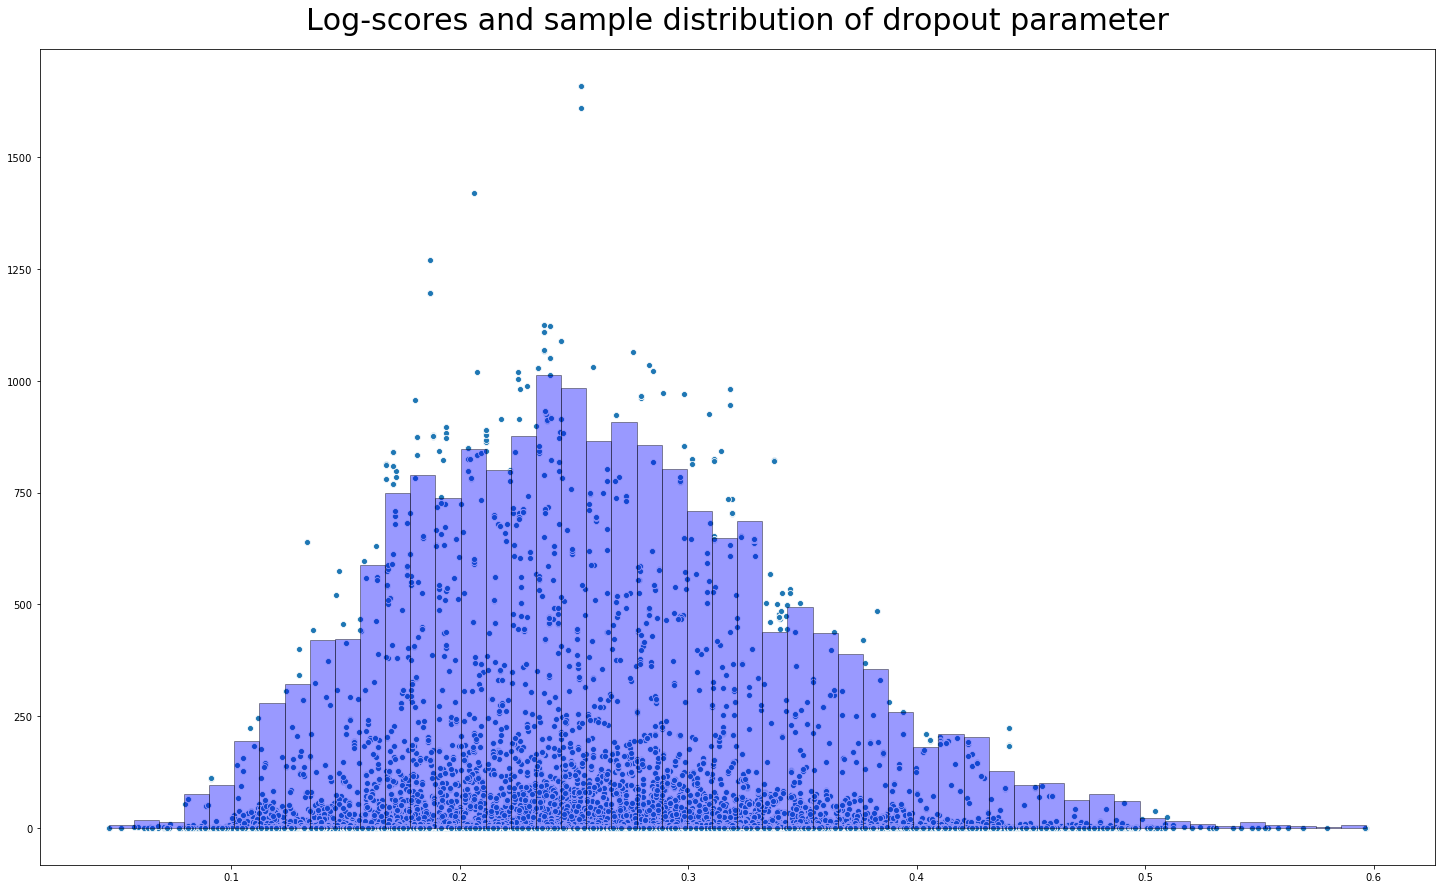

In [14]:
plt.figure(figsize = (25,15))
plt.title("Log-scores and sample distribution of dropout parameter",{'fontsize': 30}, pad = 20)
x = np.arange(0,50)

sns.scatterplot([r[2] for r in [row[0] for row in sampleParams]], ([math.e**row[1] * 7e9 for row in sampleParams]))

sns.distplot([r[2] for r in [row[0] for row in sampleParams]], hist=True, kde=False, 
             bins=50, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

Prior alpha: 	 2 				    Prior beta:  10
Alpha: 		 14.59395547700452 		    Beta: 	 193.71463203680926


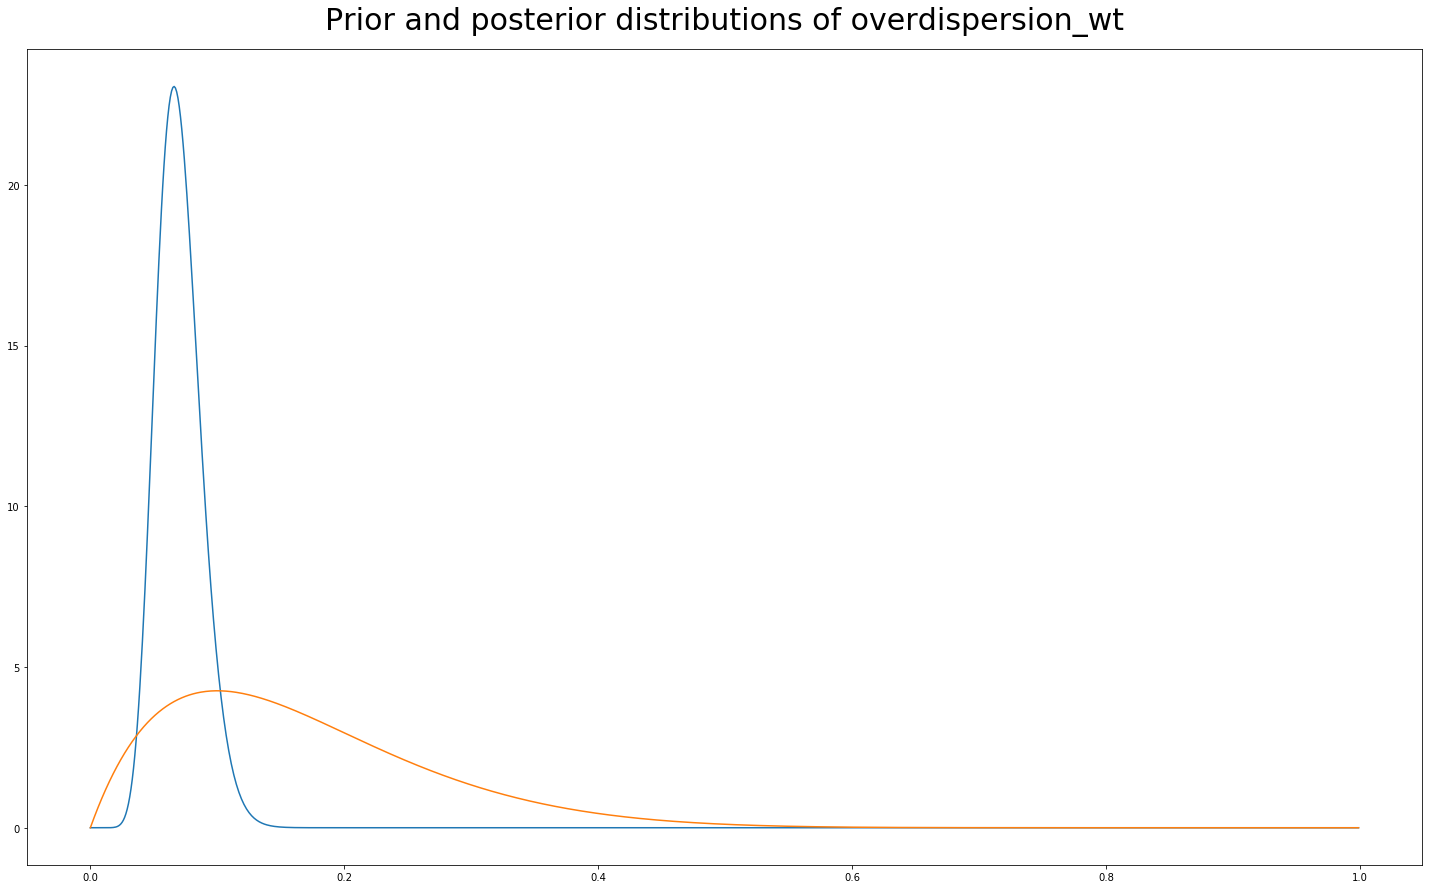

Prior alpha: 	 2 				    Prior beta:  2
Alpha: 		 8.596586374978651 		    Beta: 	 11.248000175784465


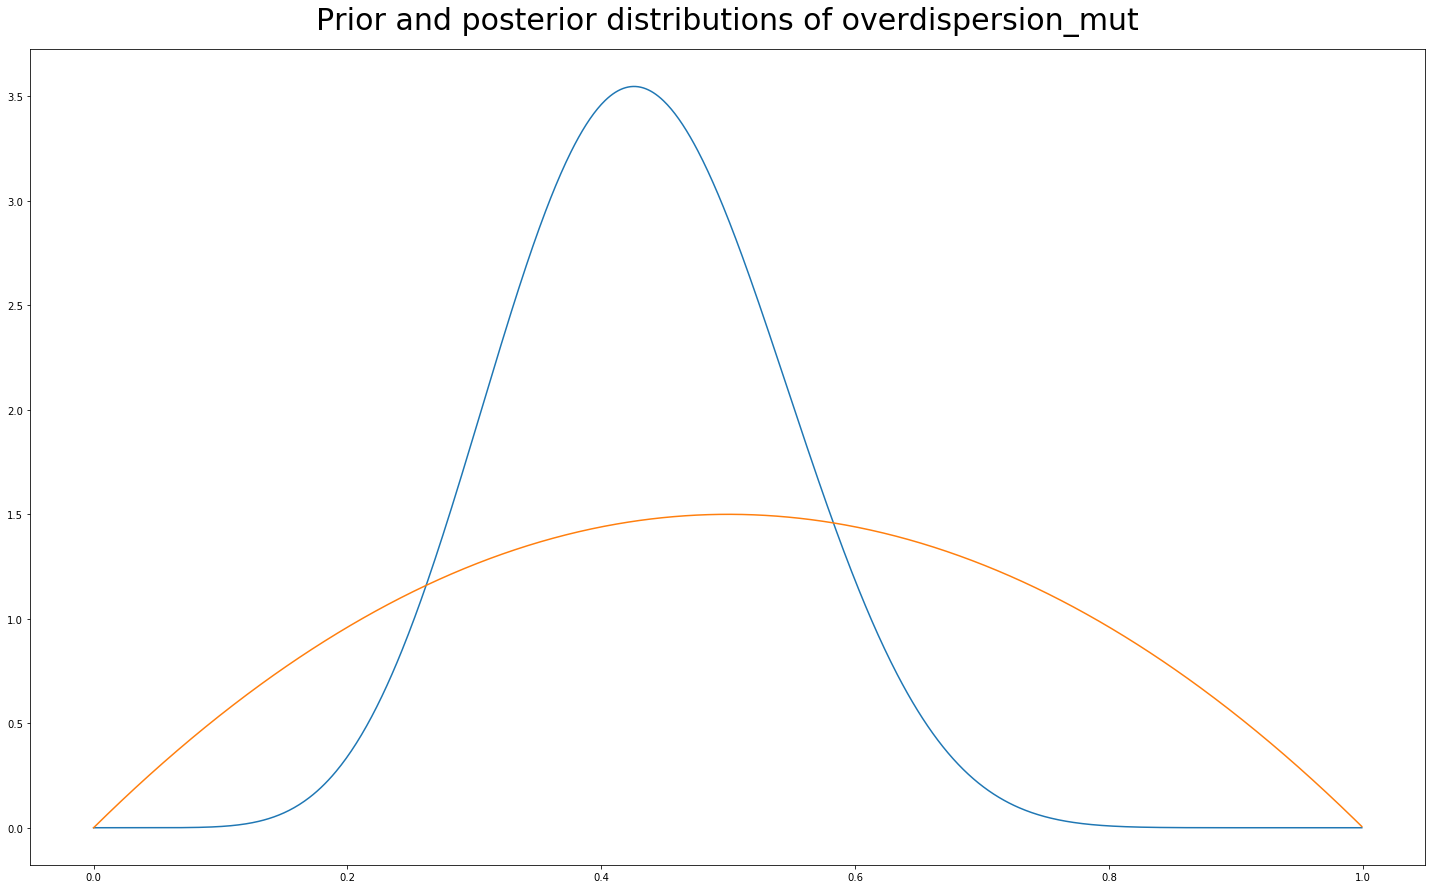

Prior alpha: 	 1.5 				    Prior beta:  3
Alpha: 		 6.829178795291674 		    Beta: 	 19.34525667161099


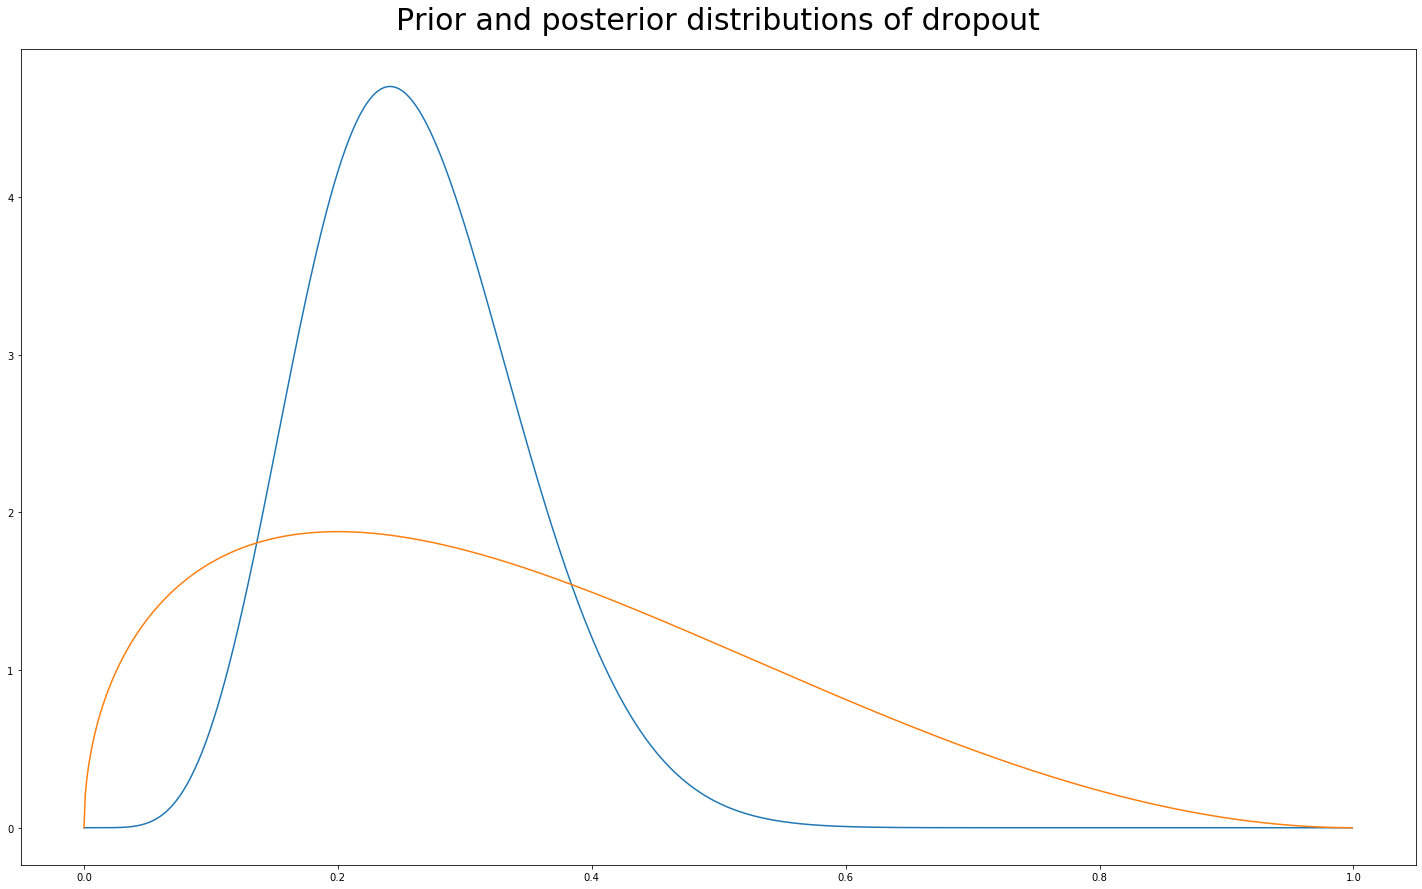

Prior alpha: 	 2 				    Prior beta:  18
Alpha: 		 12.446159951366194 		    Beta: 	 675.3160696269864


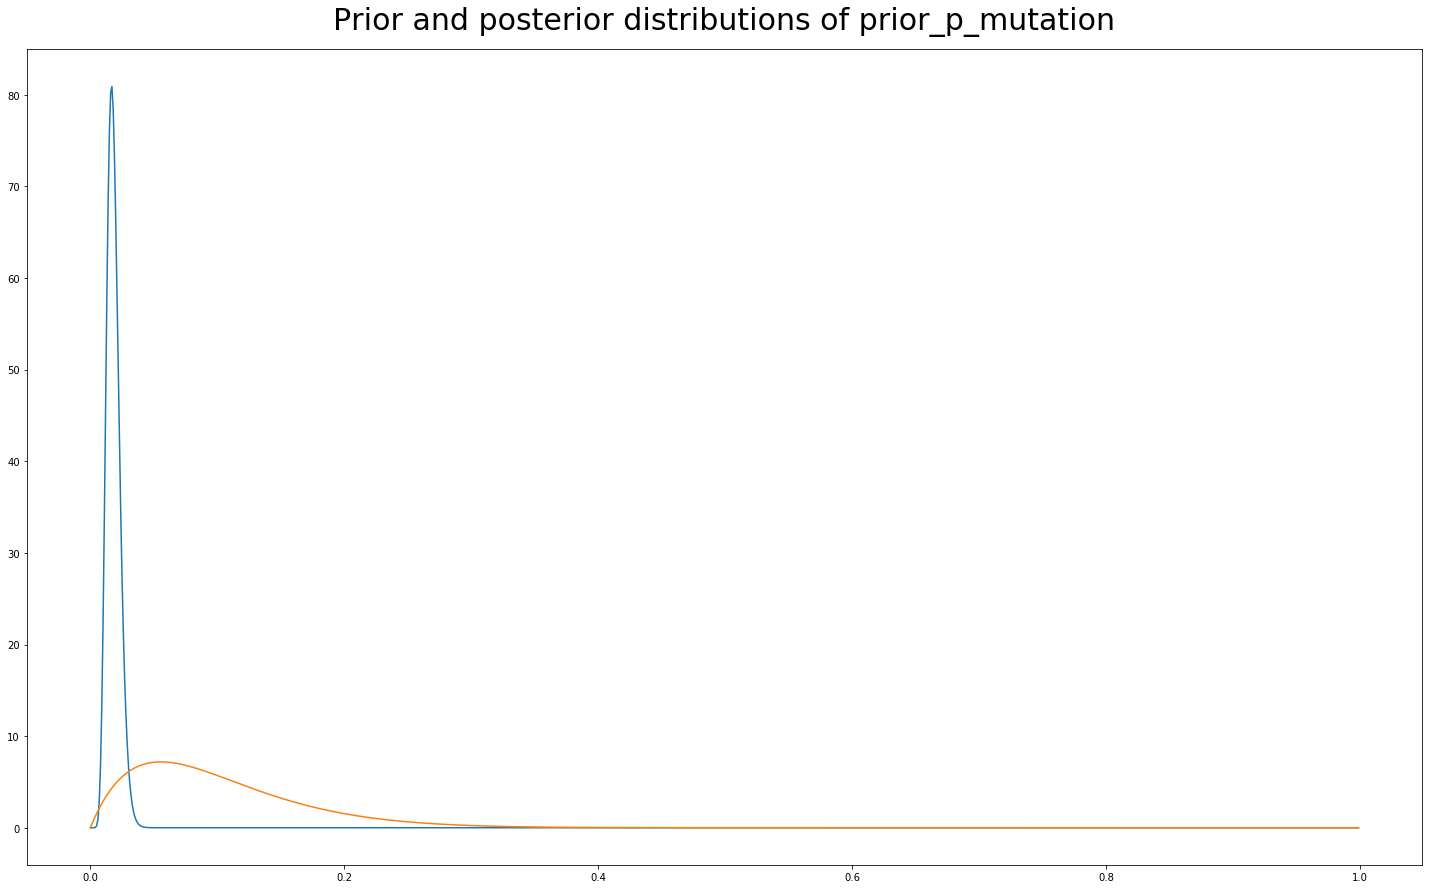

In [15]:
def pdf(a,b,x):
    return math.e**(math.lgamma(a + b) - math.lgamma(a) - math.lgamma(b)) * x**(a-1) * (1-x)**(b-1)

titles = ["Prior and posterior distributions of overdispersion_wt", "Prior and posterior distributions of overdispersion_mut", \
          "Prior and posterior distributions of dropout", "Prior and posterior distributions of prior_p_mutation"]

for n in range(4):

    # calculate alpha and beta by making use of the sampled parameters
    einm = np.array([r[n] for r in [row[0] for row in sampleParams]])
    gmeana = gmean(einm/maxValues[n])
    gmean_one = gmean((maxValues[n] - einm)/maxValues[n])
    alpha = 1/2 + gmeana / (2 * (1 - gmeana - gmean_one))
    beta = 1/2 + gmean_one / (2 * (1 - gmeana - gmean_one))

    print("Prior alpha: \t", priorAlphaBetaoodp[n*2], "\t\t\t\t", "   Prior beta: ", priorAlphaBetaoodp[n*2+1])
    print("Alpha: \t\t", alpha, "\t\t", "   Beta: \t", beta)

    plt.figure(figsize = (25,15))
    plt.title(titles[n],{'fontsize': 30}, pad = 20)
    x = np.arange(0,50)
    it = np.arange(0,1,0.001)
    beta_dis = []
    for i in it:
        beta_dis.append(pdf(alpha , beta , i))
        
    sns.lineplot(it , beta_dis)
    it = np.arange(0,1,0.001)
    beta_dis = []
    for i in it:
        beta_dis.append(pdf(priorAlphaBetaoodp[n*2], priorAlphaBetaoodp[n*2+1], i))
        
    sns.lineplot(it , beta_dis)
    plt.show()